## A simple analytical solution for slab detachment - model 2
Stefan M. Schmalholz, Earth and Planetary Science Letters 304 (2011) 45–54

In [1]:
# maybe this helps the mpi setup
import mpi4py.rc
mpi4py.rc.threaded = False
mpi4py.rc.thread_level = "single"

# import all python modules
from mpi4py import MPI
import os
import numpy as np

import underworld as uw
import glucifer

import underworld.function as fn
from underworld.scaling import units as u 
from underworld.scaling import non_dimensionalise as nd

comm = MPI.COMM_WORLD
RANK = uw.mpi.rank

# set output path
outputPath='model_b'
outputPath = os.path.abspath(outputPath)+'/'
# build output path on root proc
if RANK == 0:
    if not os.path.exists(outputPath):
        print("Making outputPath, ", outputPath)
        os.makedirs(outputPath)

In [2]:
def checkpoint( mesh, fieldDict, swarm, swarmDict, outputDir='./',
                    meshName='mesh', swarmName='swarm', time=0.,
                    enable_xdmf=True, with_deform_mesh=False):

    if 'counter' not in checkpoint.__dict__:
        checkpoint.counter = 0
        
    prefix = outputDir
    # Check the prefix is valid
    if not os.path.exists(prefix) and uw.mpi.rank==0:
        raise RuntimeError("Error checkpointing, can't find {}".format(prefix))
    if not isinstance(time, (float,int)):
        raise TypeError("'index' is not a number")
    ii = str(checkpoint.counter).zfill(5)

    # only is there's a mesh then check for fields to save
    if mesh is not None:

        # Error check the mesh and fields
        if not isinstance(mesh, uw.mesh.FeMesh):
            raise TypeError("'mesh' is not of type uw.mesh.FeMesh")
        if not isinstance(fieldDict, dict):
            raise TypeError("'fieldDict' is not of type dict")
        for key, value in fieldDict.items():
            if not isinstance( value, uw.mesh.MeshVariable ):
                raise TypeError("'fieldDict' must contain uw.mesh.MeshVariable elements")

        # Save the mesh each call of checkpoint() if with_deform_mesh is enabled
        if with_deform_mesh is True:
            mh = mesh.save(prefix+meshName+".h5")
        else:
            # see if we have already saved the mesh. It only needs to be saved once
            if 'mH' not in checkpoint.__dict__:
                checkpoint.mH = mesh.save(prefix+meshName+".h5")
            mh = checkpoint.mH

        # save xdmf files
        for key,value in fieldDict.items():
            filename = prefix+key+'-'+ii
            handle   = value.save(filename+'.h5', mh)
            if enable_xdmf: value.xdmf(filename, handle, key, mh, meshName, time)

    # is there a swarm
    if swarm is not None:

        # Error check the swarms
        if not isinstance(swarm, uw.swarm.Swarm):
            raise TypeError("'swarm' is not of type uw.swarm.Swarm")
        if not isinstance(swarmDict, dict):
            raise TypeError("'swarmDict' is not of type dict")
        for key, value in swarmDict.items():
            if not isinstance( value, uw.swarm.SwarmVariable ):
                raise TypeError("'fieldDict' must contain uw.swarm.SwarmVariable elements")

        # save xdmf files
        sH = swarm.save(prefix+swarmName+"-"+ii+".h5")
        for key,value in swarmDict.items():
            filename = prefix+key+'-'+ii
            handle   = value.save(filename+'.h5')
            if enable_xdmf: value.xdmf(filename, handle, key, sH, swarmName, time)
    
    checkpoint.counter += 1


In [3]:
# desired scaling
K_length    = 1 * u.kilometer
K_viscosity = 1e18 * u.pascal * u.second
K_density   = 1e3 * u.kilogram / (u.meter)**3

# resultant scaling
K_mass        = K_density * K_length**3
K_seconds     = K_mass / ( K_length * K_viscosity )
K_substance   = 1. * u.mole
K_temperature = 1. * u.kelvin

# define uw scaling coefficients
scaling_coeff = uw.scaling.get_coefficients()
scaling_coeff["[length]"]      = K_length.to_base_units()
scaling_coeff["[temperature]"] = K_temperature.to_base_units()
scaling_coeff["[time]"]        = K_seconds.to_base_units()
scaling_coeff["[mass]"]        = K_mass.to_base_units()

In [4]:
## complete set of model parameters

# general params
max_time      = nd( 22.56 * u.megayear)
min_viscosity = nd( 1e18 * u.Pa * u.sec)
max_viscosity = nd( 1e25 * u.Pa * u.sec)
gravity       = nd( 9.81 * u.meter / u.second**2)

# geometry params
Lx          = nd(1000 * u.kilometer)
Ly          = nd( 660 * u.kilometer)
air_depth   = nd(  40 * u.kilometer)
plate_depth = nd(  80 * u.kilometer)
slab_length = nd( 250 * u.kilometer)
slab_width  = nd(  80 * u.kilometer)

# testing for absolute density values
# mantle_density    = nd(3150 * u.kilogram / u.meter**3)
# slab_density      = nd(3300 * u.kilogram / u.meter**3)

# mantle params: density & linear viscosity
mantle_density     = nd(0 * u.kilogram / u.meter**3)
mantle_viscosity   = nd(1e21 * u.Pa * u.sec)

# slab params: density & nonlinear viscosity
slab_density       = nd(150 * u.kilogram / u.meter**3)
slab_exponent      = 4.
mu                 = 4.75e11
_mu                = nd(mu * u.Pa*u.sec**(1/slab_exponent))

DEFAULT_STRAINRATE = nd(1e-16 / u.seconds)

# numerical parameters
resFactor = 2
resX      = resFactor * 100
resY      = resFactor * 66
elType    = "Q1/dq0"

# solve setup
STOKES_NL_TOL    = 1e-2
STOKES_OUTER_TOL = 1e-5
STOKES_INNER_TOL = 1e-6

In [20]:
_mu

8.446827197684884e-14

In [5]:
# FEM mesh and variable setup
elRes    = (resX, resY)
minCoord = [0.,0.]
maxCoord = [Lx, Ly]
mesh     = uw.mesh.FeMesh_Cartesian(maxCoord=maxCoord, 
                                    minCoord=minCoord,
                                    elementRes=elRes, 
                                    elementType=elType)
vField   = mesh.add_variable(2)
pField   = mesh.subMesh.add_variable(1)
etaField = mesh.add_variable(1)

# derivative functions of FE variables
vdotv     = fn.math.dot(vField, vField)
srFn      = fn.tensor.symmetric(vField.fn_gradient)
sr_2InvFn = fn.tensor.second_invariant(srFn) # 2nd invariant of strain rate 

# lagrangian swarm setup - stores material and viscosity
swarm        = uw.swarm.Swarm(mesh)
advector     = uw.systems.SwarmAdvector(vField, swarm, order=2)
materialVar  = swarm.add_variable(count=1, dataType='int')
viscosityVar = swarm.add_variable(count=1, dataType='double')

# populate the swarm
layout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm, particlesPerCell=20)
swarm.populate_using_layout(layout)

# enable population control
population_control = uw.swarm.PopulationControl(swarm, 
                                                aggressive=False,
                                                splitThreshold=0.15, 
                                                maxDeletions=2,
                                                maxSplits=10,
                                                particlesPerCell=20)

In [6]:
# No-slip side walls, free-slip top and bottom
bottomWall = mesh.specialSets["Bottom_VertexSet"]
topWall    = mesh.specialSets["Top_VertexSet"]
leftWall   = mesh.specialSets["Left_VertexSet"]
rightWall  = mesh.specialSets["Right_VertexSet"]
iWalls     = leftWall + rightWall
allWalls   = iWalls + topWall + bottomWall

vField.data[...] = 0.0

# dirichlet conditions for model, no slip sides walls, free slip top and bottom
stokes_dBC = uw.conditions.DirichletCondition( variable        = vField, 
                                               indexSetsPerDof = (iWalls, allWalls) )

In [7]:
## build geometries

# plate geometry
p_h   = mesh.maxCoord[1] - plate_depth
array = np.array([(mesh.minCoord[0], p_h), (mesh.maxCoord[0], p_h),
                  (mesh.maxCoord[0], mesh.maxCoord[1]), (mesh.minCoord[0], mesh.maxCoord[1])])

slab2_polygon = uw.function.shape.Polygon(vertices=array)

# slab geometry
slab_x0 = mesh.maxCoord[0]/2 - slab_width/2
slab_x1 = slab_x0 + slab_width
s_h     = p_h - slab_length
array   = np.array([(slab_x0, s_h), (slab_x1, s_h),
                    (slab_x1, Ly ), (slab_x0, Ly )])
slab_polygon = uw.function.shape.Polygon(vertices=array)

# assign geometries to swarm via polygon class, this is a proxy for 
# the 2 materials - mantle material,slab material.
# As such we can add (or) the polygon (boolean) evaluation.
# to the materialVar swarm variable, i.e. (0,1) = (mantle material,slab material)
materialVar.data[:] = slab2_polygon.evaluate(swarm) + slab_polygon.evaluate(swarm)

# define for fn mappings later on
(mantleIndex,slabIndex) = (0,1)

In [8]:
## create analysis swarms

# Ds - slab tip depth single tracking particle
ts_ds      = uw.swarm.Swarm(mesh)
ts_ds_ad   = uw.systems.SwarmAdvector(vField, ts_ds, order=2)
depthVar   = ts_ds.add_variable(count=1, dataType='double')

p_coords      = np.ndarray(shape=(1, 2))
p_coords[:,0] = Lx/2.
p_coords[:,1] = slab_length

ts_ds.add_particles_with_coordinates(p_coords)
y_coord          = fn.coord()[1]
fn_ds            = fn.misc.constant(1.0) - y_coord/Ly
depthVar.data[:] = fn_ds.evaluate(ts_ds)

# width tracers - 100 points positioned down the side edges of the slab. 50 points per side.
ts_ws      = uw.swarm.Swarm(mesh)
ts_ws_ad   = uw.systems.SwarmAdvector(vField, ts_ws, order=2)
dummVar    = ts_ws.add_variable(count=1, dataType='int') # dummy var required to save

p_coords           = np.ndarray(shape=(100, 2))
p_coords[0:50,0]   = slab_x0
p_coords[0:50,1]   = np.linspace(s_h, p_h, num=50)
p_coords[50:100,0] = slab_x1
p_coords[50:100,1] = np.linspace(s_h, p_h, num=50)

ignore = ts_ws.add_particles_with_coordinates(p_coords)

In [9]:
# setup velocity vis
figVel = glucifer.Figure(title="Velocity arrows and 2nd inv strain rate")
figVel.append(glucifer.objects.VectorArrows(mesh, vField))
figVel.append(glucifer.objects.Surface(mesh, sr_2InvFn, logScale=True))
# figVel.show()

In [10]:
# assign Fns for phyical properties

# Density
densityFn     = uw.function.branching.map( fn_key=materialVar, 
                                           mapping={ slabIndex: slab_density, mantleIndex: mantle_density } )
# Force
forceFn       = gravity*densityFn * (0.0,-1.)

# Viscosity
dummy_sr_2Inv = fn.misc.constant(DEFAULT_STRAINRATE)

# strain rate and power-law viscosity
sr      = fn.misc.max(sr_2InvFn, dummy_sr_2Inv)
eta_raw = _mu*fn.math.pow(sr, (1./slab_exponent - 1.))

# viscous limiting
maxBound       = fn.misc.min(eta_raw,  max_viscosity)
finalViscosity = fn.misc.max(maxBound, min_viscosity)

viscosityFn = uw.function.branching.map( fn_key=materialVar, 
                                         mapping={ slabIndex: finalViscosity, mantleIndex: mantle_viscosity } )

In [11]:
# setup solver
stokes = uw.systems.Stokes( velocityField = vField, 
                            pressureField = pField,
                            conditions    = [stokes_dBC],
                            fn_viscosity  = viscosityFn, 
                            fn_bodyforce  = forceFn )
solver = uw.systems.Solver( stokes )

solver.set_outer_rtol(STOKES_OUTER_TOL)
solver.set_inner_method("mumps") # direct solve for speed

In [12]:
figEta = glucifer.Figure(title="Viscosity [Pa*s]")
factor = 1/nd(1*u.Pa*u.s)
figEta.append(glucifer.objects.Points(swarm, factor*viscosityFn, logScale=True, fn_size=2.0))

figEps = glucifer.Figure(title="Strain Rate 2nd inv. [1/s]")
factor = 1/nd(1*u.s**-1)
figEps.append(glucifer.objects.Points(swarm, factor*sr_2InvFn, logScale=True, fn_size=2.0))

figRho = glucifer.Figure(title="Density [kg/m**3]")
factor = 1/nd(1*u.kg/u.m**3)
figRho.append(glucifer.objects.Points(swarm, factor*densityFn))


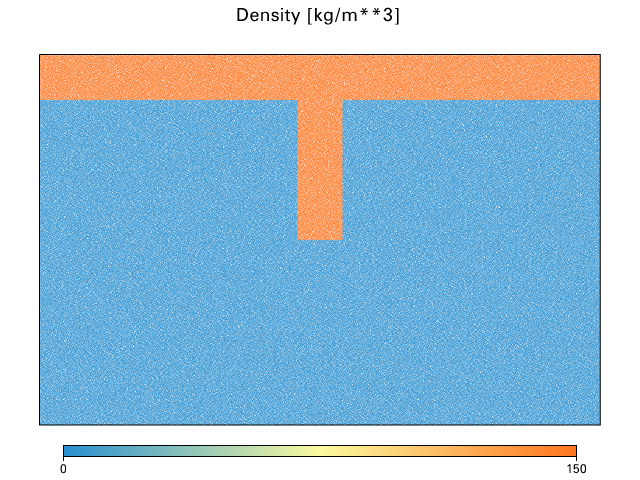

In [13]:
figRho.show()

In [14]:
# # Get solution
# solver.solve(nonLinearIterate=True,nonLinearTolerance=1e-2)
# projection = uw.utils.MeshVariable_Projection(etaField, stokes.fn_viscosity)
# projection.solve()

# fieldDict = {'velocity':vField, 'viscosityField':etaField}
# checkpoint( mesh, fieldDict, None, None, 0, outputDir=outputPath) # for initial analysis

In [15]:
# redefine
swarmDict = {'viscosity':viscosityVar}
fieldDict = {'velocity':vField}

In [16]:
# simulation parameters
steps         = 0
finalTimestep = 5
curTime       = 0
cp_i          = 0
chkpt_every   = 1 # in numeric steps

# Wall time timers
timer_0, timer_1 = 0,0

if RANK == 0:
    outfile = open(outputPath+'buildMount.txt', 'w+')
    string = "steps, timestep, time, vrms, slab_tip_depth, Wtime"
    print(string)
    outfile.write( string+"\n")

# initialise loop
dt = -1

timer_0 = MPI.Wtime()
while steps<finalTimestep:
# while curTime < max_time:
    
    depthVar.data[:] = fn_ds.evaluate(ts_ds)
    
    # Get solution
    solver.solve(nonLinearIterate=True,nonLinearTolerance=STOKES_NL_TOL)
    
    viscosityVar.data[:] = stokes.fn_viscosity.evaluate(swarm)
    
    if steps % chkpt_every == 0:
        checkpoint( mesh, fieldDict, swarm, swarmDict, 
                    outputDir=outputPath, time=curTime)
        cp_i += 1 # due to paraview 5.4 oddity
    ts_ws.save(outputPath+'/width_swarm.'+str(steps).zfill(4)+'.h5')
    
    # calculate metrics
    v2int = mesh.integrate(fn=vdotv)[0]
    vol   = mesh.integrate(fn=1.0)[0]
    
    s_d = 0
    if ts_ds.particleLocalCount>0: 
        s_d = depthVar.data[0][0]
    s_d = comm.allreduce(s_d)
    
    # get time step first time around
    if dt < 0:
        dt = advector.get_max_dt()
    
    curTime += dt
    timer_1 = MPI.Wtime()
    string = "{}, {:.5e}, {:.5e}, {:.5e}, {:.5e}, {:.5e}".format(steps,
                                 uw.scaling.dimensionalise(dt, u.year),
                                 uw.scaling.dimensionalise(curTime, u.year),
                                 uw.scaling.dimensionalise(np.sqrt(v2int/vol), u.cm/u.year), 
                                 s_d,
                                 (timer_1-timer_0) )
    timer_0 = timer_1
    if RANK == 0:
        print(string)
        outfile.write(string+"\n")
        
    figEta.save(outputPath+"eta-"+str(steps)+".png")
    figEps.save(outputPath+"eps-"+str(steps)+".png")
    
    # Advect particles   
    advector.integrate(dt)
    ts_ws_ad.integrate(dt)
    ts_ds_ad.integrate(dt)
    # population control
    population_control.repopulate()  
    
    steps += 1

if RANK==0:
    outfile.close()

steps, timestep, time, vrms, slab_tip_depth, Wtime
0, 1.17117e+06 year, 1.17117e+06 year, 6.36259e-02 centimeter / year, 6.21212e-01, 5.75475e+01
1, 1.17117e+06 year, 2.34235e+06 year, 6.79727e-02 centimeter / year, 6.23789e-01, 5.56633e+01
2, 1.17117e+06 year, 3.51352e+06 year, 7.18339e-02 centimeter / year, 6.26571e-01, 6.53907e+01
3, 1.17117e+06 year, 4.68470e+06 year, 7.70832e-02 centimeter / year, 6.29482e-01, 3.22878e+01
4, 1.17117e+06 year, 5.85587e+06 year, 8.28927e-02 centimeter / year, 6.32635e-01, 4.68348e+01



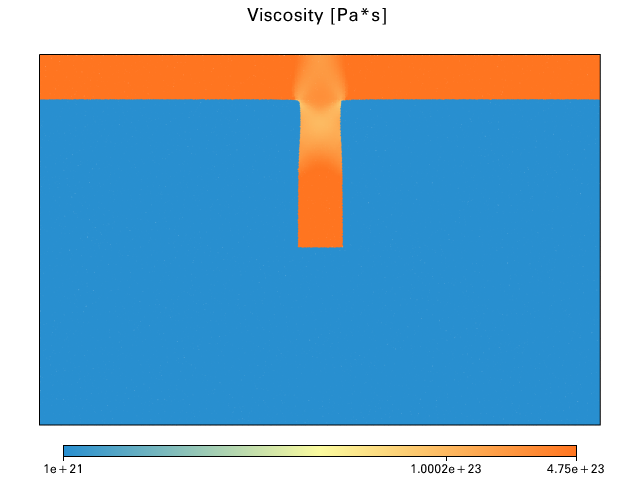

In [19]:
figEta.show()